**Objective:** In this notebook, we are going to be creating several machine learning models for the predictions of energy generated by a wind turbine system, given the weather conditions an hour prior.

(TARGET COLUMN is System power generated)

**Metrics:** Mean Squared Error and Mean Absolute Error

**WORKFLOW:** In order to accomplish the above goal, we need to perform the following:

1. Data Loading and Understanding
2. Cleaning the Data
3. Feature Engineering
4. Exploratory Data Analysis
5. Modelling
6. Hyperparameter Tuning
7. Model Selection
8. Inference Scrip Creation

**Data Loading**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
data = pd.read_csv('TexasTurbine.csv')

In [6]:
data.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


In [7]:
data.tail()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
8755,"Dec 31, 07:00 pm",1234.70,8.848,129,0.998604,19.663
8756,"Dec 31, 08:00 pm",1105.37,8.502,118,1.000090,19.063
8757,"Dec 31, 09:00 pm",1405.71,9.224,117,0.998408,18.463
8758,"Dec 31, 10:00 pm",1221.36,8.799,116,0.998013,18.063
8759,"Dec 31, 11:00 pm",1676.77,9.748,121,1.000380,18.163


In [8]:
data.columns

Index(['Time stamp', 'System power generated | (kW)', 'Wind speed | (m/s)',
       'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)'],
      dtype='object')

In [9]:
# Getting the dimension of the data
data.shape

(8760, 6)

# Data Cleaning 

1. check for missing data
2. Fix the timestamp
3. Set the timestamp as index
4. Check for duplicates

In [12]:
# Check for misiing values : filna(method, value)
data.isna().sum()/len(data)*100

Time stamp                       0.0
System power generated | (kW)    0.0
Wind speed | (m/s)               0.0
Wind direction | (deg)           0.0
Pressure | (atm)                 0.0
Air temperature | ('C)           0.0
dtype: float64

In [13]:
data['Time stamp']

0        Jan 1, 12:00 am
1        Jan 1, 01:00 am
2        Jan 1, 02:00 am
3        Jan 1, 03:00 am
4        Jan 1, 04:00 am
              ...       
8755    Dec 31, 07:00 pm
8756    Dec 31, 08:00 pm
8757    Dec 31, 09:00 pm
8758    Dec 31, 10:00 pm
8759    Dec 31, 11:00 pm
Name: Time stamp, Length: 8760, dtype: object

In [113]:
# First, inspect the first few rows to verify the format
print(data['Time stamp'].head())

# Convert 'Time stamp' to datetime, fixing the format
data['Time stamp'] = pd.to_datetime(data['Time stamp'], format='%b %d, %I:%M %p', errors='coerce')

# Replace year '1900' with '2021' if necessary
data['Time stamp'] = data['Time stamp'].apply(lambda x: x.replace(year=2021) if x.year == 1900 else x)

# Verify conversion
print(data['Time stamp'].head())


0    Jan 1, 12:00 am
1    Jan 1, 01:00 am
2    Jan 1, 02:00 am
3    Jan 1, 03:00 am
4    Jan 1, 04:00 am
Name: Time stamp, dtype: object
0   2021-01-01 00:00:00
1   2021-01-01 01:00:00
2   2021-01-01 02:00:00
3   2021-01-01 03:00:00
4   2021-01-01 04:00:00
Name: Time stamp, dtype: datetime64[ns]


In [115]:
# ✅ Sets the 'Time stamp' column as the new index of the DataFrame.
# 📌 This means that instead of using default integer indices (0, 1, 2, ...), the timestamps will now be used to index the data.


data.index = data['Time stamp'] 
data.drop('Time stamp', axis = 1, inplace = True)
# ✅ Removes the 'Time stamp' column from the DataFrame since it is now redundant (already used as an index).

In [16]:
data.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
Time stamp,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963


In [17]:
# Checking the duplicated values
data.duplicated().sum()

0

# Feature Engineering 

In [9]:
## Extract the following information from date index: day of week, week, month, quarter

def extract_features(dataframe):
    """
    This function extracts date features from the index and also creates a season column.
    """
    # Copy dataframe
    dataframe = dataframe.copy()
    dataframe['quarter'] = dataframe.index.quarter
    dataframe['month'] = dataframe.index.month
    dataframe['week'] = dataframe.index.isocalendar().week.astype(int)
    dataframe['hour'] = dataframe.index.hour
    
    return dataframe

def map_month_to_season(month):
    if 3 <= month <= 5:
        return "Spring"
    elif 6 <= month <= 8:
        return "Summer"
    elif 9 <= month <= 11:
        return "Fall"
    else:
        return "Winter"


In [117]:
# Function to extract date-related features from the index
def extract_features(dataframe):
    """
    This function extracts date features from the index 
    and also creates a season column.
    """

    # Create a copy of the dataframe to avoid modifying the original data
    dataframe = dataframe.copy()

    # Extract the quarter (1st, 2nd, 3rd, or 4th quarter of the year)
    dataframe['quarter'] = dataframe.index.quarter

    # Extract the month number (1-12)
    dataframe['month'] = dataframe.index.month

    # Extract the week number of the year
    dataframe['week'] = dataframe.index.isocalendar().week.astype(int)

    # Extract the hour from the timestamp
    dataframe['hour'] = dataframe.index.hour

    return dataframe  # Return the modified dataframe

# Function to map month numbers to seasons
def map_month_to_season(month):
    # Check if the month falls in Spring (March to May)
    if 3 <= month <= 5:
        return "Spring"

    # Check if the month falls in Summer (June to August)
    elif 6 <= month <= 8:
        return "Summer"

    # Check if the month falls in Fall (September to November)
    elif 9 <= month <= 11:
        return "Fall"

    # If none of the above, it must be Winter (December to February)
    else:
        return "Winter"


In [119]:
extract_features(data).head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C),quarter,month,week,hour
Time stamp,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4


In [121]:
data =  extract_features(data)

In [125]:
data['season'] = data['month'].apply(map_month_to_season)

In [127]:
data.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C),quarter,month,week,hour,season
Time stamp,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter


In [25]:
# View my data types 
data.dtypes

System power generated | (kW)    float64
Wind speed | (m/s)               float64
Wind direction | (deg)             int64
Pressure | (atm)                 float64
Air temperature | ('C)           float64
quarter                            int32
month                              int32
week                               int32
hour                               int32
season                            object
dtype: object

In [129]:
data.columns

Index(['System power generated | (kW)', 'Wind speed | (m/s)',
       'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)',
       'quarter', 'month', 'week', 'hour', 'season'],
      dtype='object')

In [131]:
# Modify the column names
data.columns = ['power_generated', 'wind_speed',
       'wind_dir', 'pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season']

In [133]:
data.head()

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season
Time stamp,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter


# Exoloratory Data Analysis

# Univariate Analysis: power generated', 'wind speed', wind dire', 'pressure', 'temperature and season

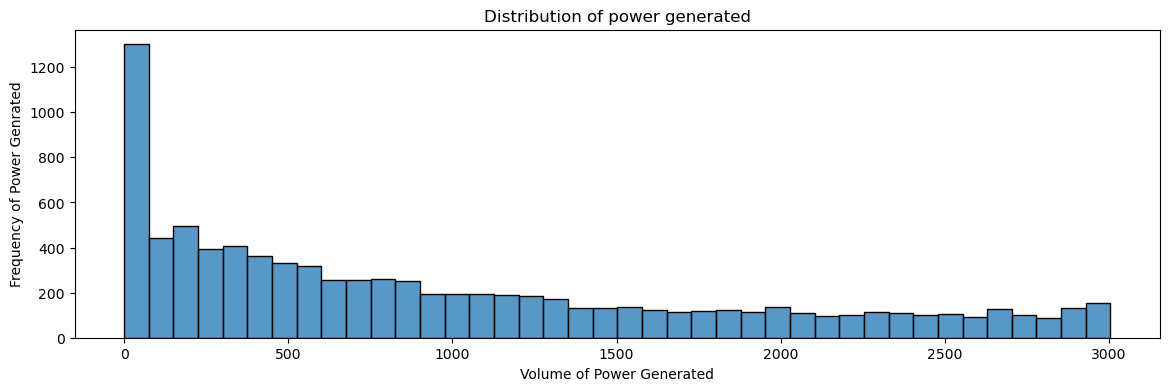

In [137]:
# Visualising the distribution of power generated 

# Specify the plot size
plt.figure(figsize = (14, 4))
sns.histplot(data['power_generated'], bins = 40)

plt.title('Distribution of power generated')
plt.xlabel('Volume of Power Generated')
plt.ylabel('Frequency of Power Genrated')
plt.show()

In [139]:
data.power_generated.mean()

964.4679340166095

In [141]:
# Stat report on power_generated column
data.power_generated.describe()

count    8760.000000
mean      964.467934
std       878.558112
min         0.000000
25%       215.951500
50%       693.968500
75%      1562.287500
max      3004.010000
Name: power_generated, dtype: float64

In [143]:
# Selecting Null Power Generated rows
data[data['power_generated']<= 0]

# In 822 instances, we get power gen to be 0

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season
Time stamp,,,,,,,,,,
2021-01-05 00:00:00,0.0,2.491,156,0.991694,20.263,1,1,1,0,Winter
2021-01-05 01:00:00,0.0,0.484,95,0.994162,19.963,1,1,1,1,Winter
2021-01-07 22:00:00,0.0,2.788,340,1.002560,10.863,1,1,1,22,Winter
2021-01-07 23:00:00,0.0,2.116,273,1.001870,11.963,1,1,1,23,Winter
2021-01-08 00:00:00,0.0,2.897,284,1.000980,12.063,1,1,1,0,Winter
...,...,...,...,...,...,...,...,...,...,...
2021-12-27 23:00:00,0.0,2.748,241,0.997129,13.863,4,12,52,23,Winter
2021-12-28 00:00:00,0.0,2.135,271,0.996338,14.163,4,12,52,0,Winter
2021-12-28 01:00:00,0.0,2.076,246,0.996338,14.163,4,12,52,1,Winter


In [145]:
# Getting count of season where power generation is zero
data[data['power_generated']<= 0]['season'].value_counts()

season
Fall      284
Winter    239
Summer    191
Spring    108
Name: count, dtype: int64

# Interpretation of Power Outages Across Seasons
This output provides insight into how frequently power generation drops to zero or below across different seasons.

**Key Observations**

**1. Fall (284 occurrences)** → Most frequent outages occur in Fall.

**2. Winter (239 occurrences)** → Second highest outages, possibly due to extreme cold weather affecting power generation.

**3. Summer (191 occurrences)** → Moderate outages, which could be linked to high energy demands.

**4. Spring (108 occurrences)** → Least number of outages, suggesting more stable power generation during this season.

C:\Users\USER\AppData\Local\Temp\ipykernel_15688\2280143340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = season_counts.index, y = season_counts, palette = 'viridis')


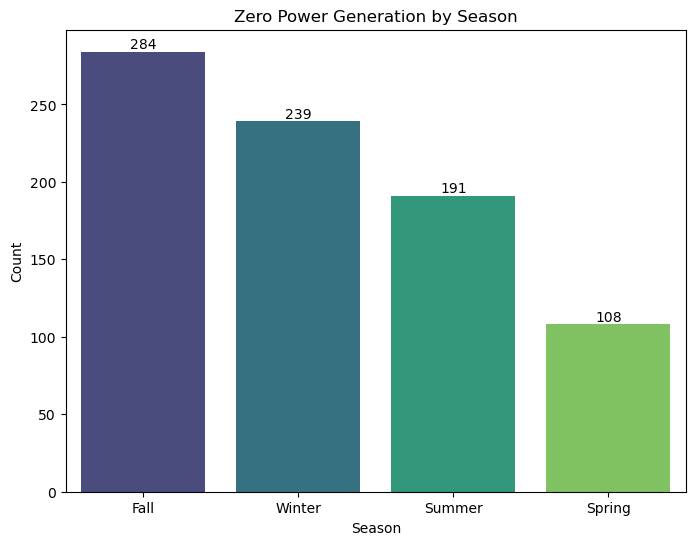

In [147]:
season_counts = data[data['power_generated']<= 0]['season'].value_counts()

plt.figure(figsize = (8,6))
ax = sns.barplot(x = season_counts.index, y = season_counts, palette = 'viridis')

for p in ax.containers:
    ax.bar_label(p)

plt.title('Zero Power Generation by Season')
plt.ylabel('Count')
plt.xlabel('Season')
plt.show(); plt.close('all')

<Axes: ylabel='power_generated'>

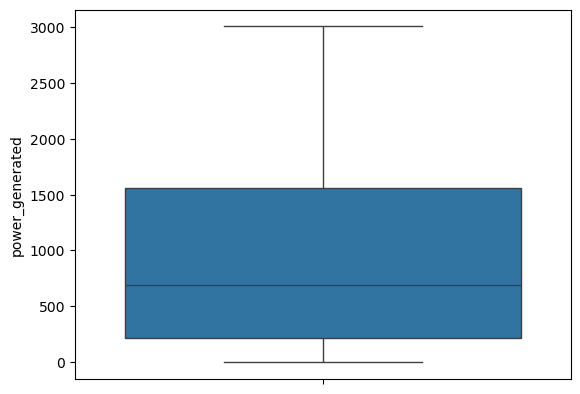

In [38]:
# Power generated in Boxplot
sns.boxplot(data['power_generated'])

**There is absent of outliers in power generated**

In [40]:
data.columns

Index(['power_generated', 'wind_speed', 'wind_dir', 'pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season'],
      dtype='object')

<Axes: xlabel='wind_speed', ylabel='Count'>

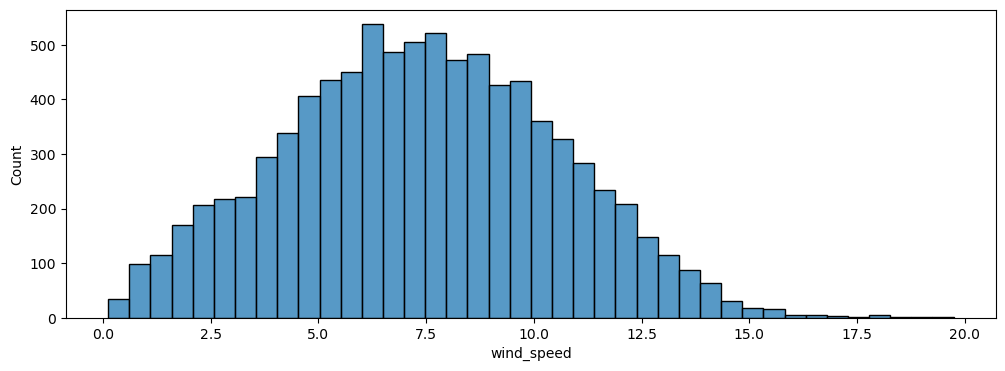

In [41]:
# Checking for the distribution of wind speed
plt.figure(figsize = (12,4))
sns.histplot(data['wind_speed'], bins = 40, )

**Wind speed is normally distributed**

<Axes: ylabel='wind_dir'>

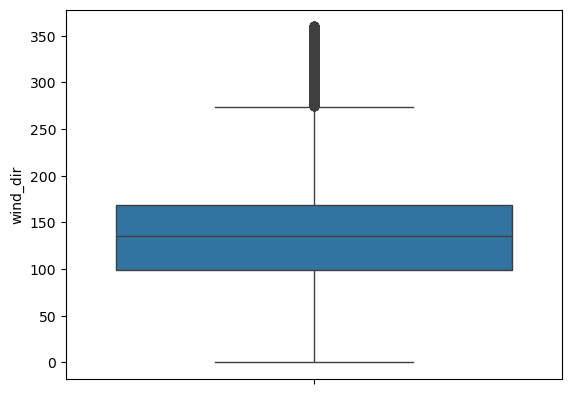

In [43]:
sns.boxplot(data['wind_dir'])

# There is outliers in wind direction, but the severity is not too much 
# You could remove the outliers by capping or transforming

<Axes: xlabel='wind_dir', ylabel='Count'>

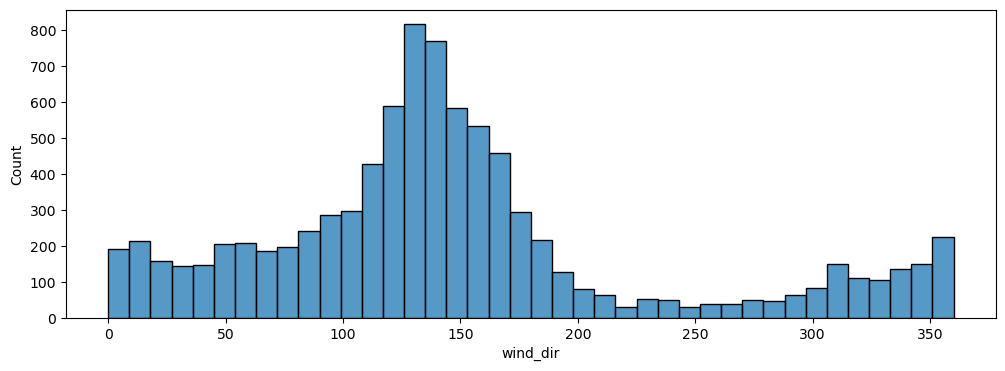

In [44]:
plt.figure(figsize = (12, 4))
sns.histplot(data['wind_dir'], bins = 40)

**Wind direction is (in angle) not strictly normal.**

**Key Observations**

**1. Wind Direction Range:**

- The values range from 0° to 360°, which aligns with standard meteorological wind direction measurements.

 - Wind direction is measured in degrees, where:

    - 0° (or 360°) → North

    - 90° → East

    - 180° → South

    - 270° → West

**2. Most Common Wind Directions:**

- The highest frequency is observed around 120° to 160°, suggesting that winds predominantly come from the Southeast (SE) direction.

- There are also secondary peaks around 0° and 350°, indicating some winds from the North (N) and Northwest (NW).

**3. Less Frequent Wind Directions:**

- The frequency drops significantly between 200° and 300°, suggesting that winds from the Southwest (SW) and West (W) are less common.

**4. Possible Meteorological Influence:**

- This distribution might reflect seasonal wind patterns or dominant trade winds in the region.

- The high frequency of SE winds could indicate a climatic or geographical factor influencing wind flow.
- 
**Key Insights**
- Most winds come from the Southeast (120°–160°).

- There are occasional winds from the North and Northwest.

- Southwest and West winds are rare.

- This distribution can help in wind energy studies, weather forecasting, and aerodynamics research.

In [149]:
data.groupby('season')['wind_dir'].value_counts().unstack()

wind_dir,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
season,,,,,,,,,,,,,,,,,,,,,
Fall,6.0,10.0,9.0,13.0,10.0,9.0,8.0,14.0,10.0,6.0,...,8.0,13.0,20.0,10.0,15.0,10.0,10.0,13.0,12.0,7.0
Spring,1.0,6.0,2.0,6.0,NaN,5.0,3.0,7.0,4.0,4.0,...,3.0,NaN,3.0,4.0,NaN,4.0,3.0,6.0,3.0,NaN
Summer,2.0,3.0,1.0,1.0,NaN,2.0,2.0,NaN,2.0,NaN,...,NaN,NaN,3.0,2.0,1.0,NaN,1.0,2.0,NaN,NaN
Winter,5.0,4.0,7.0,7.0,5.0,8.0,6.0,5.0,8.0,11.0,...,8.0,12.0,8.0,7.0,8.0,8.0,4.0,9.0,5.0,2.0


Text(0.5, 1.0, 'Distribution of Pressure')

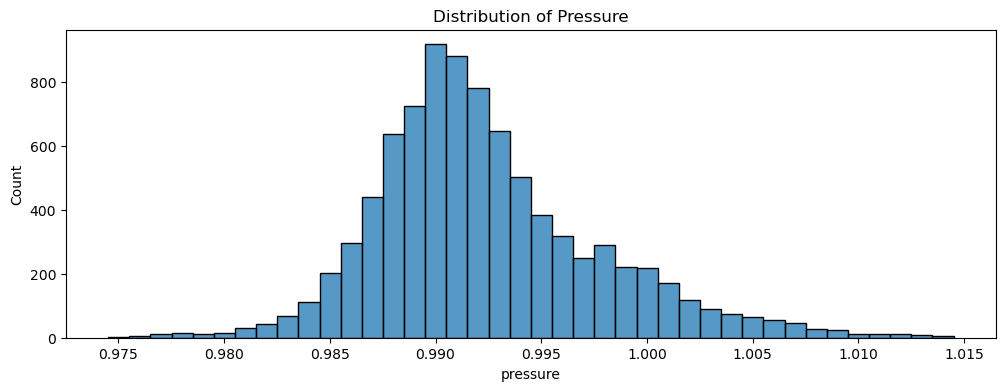

In [151]:
# Showing the distribution of pressure value
plt.figure(figsize = (12, 4))
sns.histplot(data['pressure'], bins = 40)
plt.title('Distribution of Pressure')

**Key Observations**
1. Shape of Distribution:

- The distribution is approximately normal (bell-shaped), indicating that most pressure values are concentrated around a central point.

 -This suggests a stable atmospheric pressure trend with minimal extreme variations.

**Pressure is normally distributed**

2. Most Common Pressure Range:

- The highest frequency occurs around 0.990 to 0.995 (most common pressure values).

- The mean pressure appears to be slightly below 1.000.

3. Range of Pressure Values:

- The values range from approximately 0.975 to 1.015, indicating a narrow spread.

- There are fewer occurrences of extremely low (<0.98) or high (>1.01) pressure values.

4. Possible Meteorological Influence:

- Low-pressure systems (<0.98) might indicate stormy or unsettled weather.

- High-pressure systems (>1.01) may suggest calm and stable weather conditions.

- The dominance of values around 0.990-0.995 suggests a stable atmospheric condition with mild variations.

**Key Insights**

- Pressure follows a normal distribution.

- Most values fall between 0.990 and 0.995.

- Extreme pressure values are rare.

- This analysis can help in understanding weather patterns, power generation efficiency, and forecasting applications.

Text(0.5, 1.0, 'Distribution of Temperature')

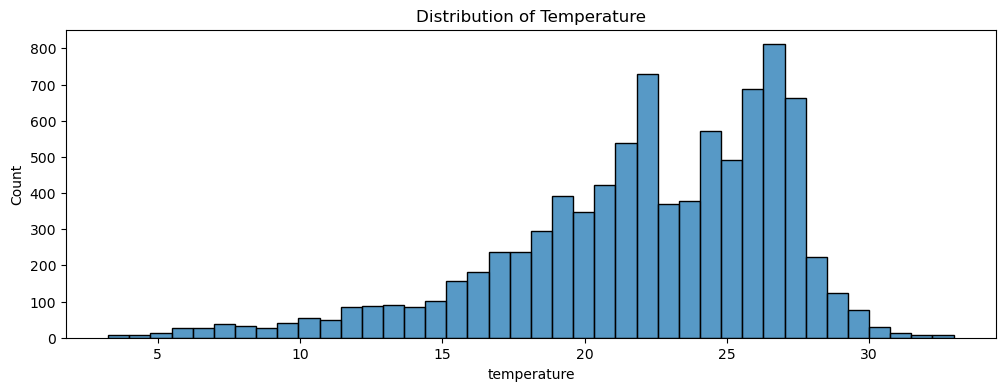

In [50]:
plt.figure(figsize = (12, 4))
sns.histplot(data['temperature'], bins = 40)
plt.title('Distribution of Temperature')

**Key Observations**

**1. Temperature Range:**

- The lowest temperature is around 5°C, while the highest is slightly above 30°C.

- Most temperatures fall between 15°C and 30°C, with a noticeable peak around 25°C.

**2. Most Frequent Temperatures:**

- The highest frequency is seen between 22°C and 27°C, with the peak around 25°C.

- This suggests that the typical temperature stays within this range for a significant portion of the dataset.

**3. Distribution Shape:**

- The distribution appears right-skewed, with fewer occurrences of extremely low temperatures.

- There are gradually increasing values up to 25°C, followed by a slower decline beyond 27°C.

**4. Possible Seasonal Influence:**

- The peak around 25°C may indicate a warmer season.

- The lower frequency of extreme cold (<10°C) suggests that very cold temperatures are rare.


**Key Insights**
- Most temperatures are clustered around 22–27°C, making it the most common temperature range.

- Extreme cold (<10°C) and extreme heat (>30°C) are rare.

- This distribution can help in weather forecasting, energy demand analysis, and climate pattern studies.

**Temperature is right-skewed, probably due to the fact that there are more warmers days**

In [153]:
data.groupby('season')['temperature'].value_counts()

season  temperature
Fall    24.263         37
        24.363         37
        24.463         35
        24.663         33
        23.363         32
                       ..
Winter  27.663          1
        28.063          1
        28.163          1
        28.563          1
        28.863          1
Name: count, Length: 928, dtype: int64

# EDA: Multivariate

Text(0.5, 1.0, 'Relationship between Temperature and Pressure')

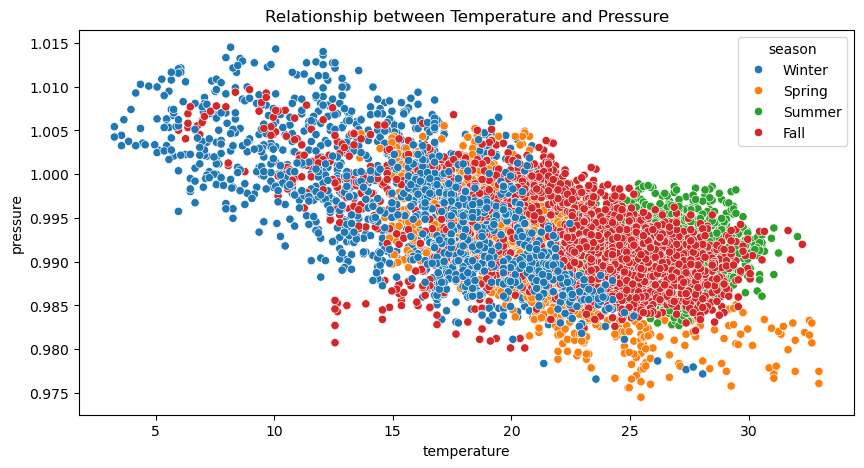

In [155]:
# Temperature vs Pressure

plt.figure(figsize = (10,5))
sns.scatterplot(data = data, x = 'temperature', y = 'pressure', hue = 'season')
plt.title('Relationship between Temperature and Pressure')

**Key Observations**

**1. Negative Correlation:**

- As temperature increases, pressure decreases.

- This suggests an inverse relationship between temperature and pressure.

**2. Linear Trend:**

- The data points form a clear downward pattern, indicating a strong negative correlation.

- This aligns with the ideal gas law (PV = nRT)—when temperature increases, pressure decreases if volume remains constant.

**3. Data Distribution:**

- Temperature ranges from ~5°C to ~30°C, and pressure ranges from ~0.975 to ~1.015.

- Most data points are densely packed in the middle range (temperature: 15-25°C, pressure: 0.985-1.000).

**4. Possible Meteorological Explanation:**

- Lower temperatures (~5-15°C) correspond to higher pressure, which often indicates stable or cold weather conditions.

- Higher temperatures (~25-30°C) correspond to lower pressure, which can be linked to unstable, warm, or stormy weather.

**Key Insights**

- Pressure decreases as temperature increases (inverse relationship).

- Data suggests a strong negative correlation (possible linear relationship).

- This relationship is consistent with atmospheric science and thermodynamics.

**Interpretation of Temperature vs. Pressure Scatter Plot (Seasonal Breakdown)**

This scatter plot enhances the previous analysis by color-coding data points by season, making it easier to observe seasonal variations in the relationship between temperature and pressure.

**Key Observations**

1. Negative Correlation (Across All Seasons)

 - The overall trend remains: as temperature increases, pressure decreases.

 - This supports the strong inverse relationship seen before.

2. Seasonal Distribution:

- Winter (Blue):

    - Concentrated in the low-temperature, high-pressure region (5-15°C, 0.995-1.010).

    - Suggests cold weather is associated with higher pressure.

- Spring (Orange):

    - Appears between Winter and Summer, with moderate temperatures and pressures.

- Summer (Green):

    - Mostly in the high-temperature, low-pressure region (25-30°C, 0.980-0.995).

    - Lower atmospheric pressure aligns with warmer conditions.

- Fall (Red):

    - Overlaps with both Spring and Summer, showing a transition phase.

**Physical Explanation:**

- In winter, cold, dense air results in higher pressure.

- In summer, warmer air expands and leads to lower pressure.

- Spring & Fall act as transition phases.

**Key Takeaways**

- ✔ The negative correlation between temperature and pressure holds across all seasons.
  
- ✔ Winter shows the highest pressures, while summer has the lowest.

- ✔ Spring and Fall show transitional behaviors between extreme seasons.

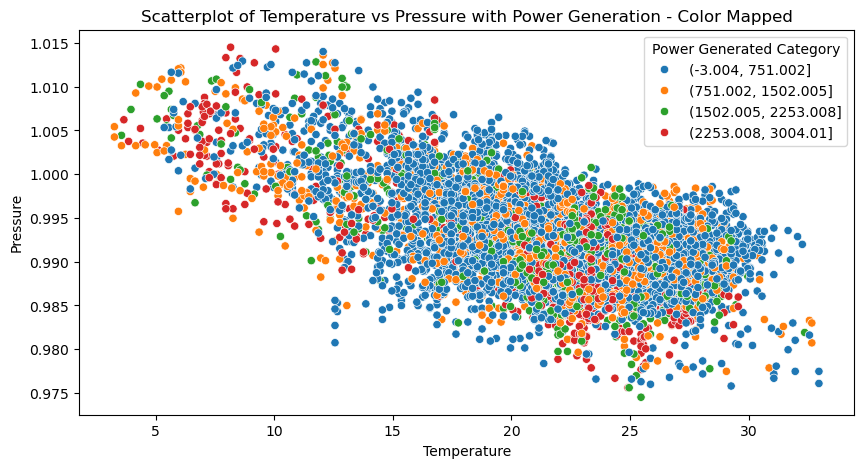

In [41]:
# Define the number of bins for categorizing 'power_generated' values
num_bins = 4  # This splits the data into 4 discrete intervals

# Create bins of power-generated values using the pd.cut function
binned_data = pd.cut(data['power_generated'], bins=num_bins)

# Create the figure and specify its size
plt.figure(figsize=(10, 5))  # Setting figure size to 10x5 inches

# Create a scatter plot with color mapping based on binned power generation
sns.scatterplot(data=data, x='temperature', y='pressure', hue=binned_data)

# Add title, x-axis label, and y-axis label
plt.title("Scatterplot of Temperature vs Pressure with Power Generation - Color Mapped")
plt.xlabel("Temperature")  # Label for x-axis
plt.ylabel("Pressure")  # Label for y-axis

# Add legend with a custom title and specify its location
plt.legend(title="Power Generated Category", loc="upper right")

# Display the plot
plt.show()

**Nothing to infer other than the large amount of blue dot (0.751)**

Text(0.5, 1.0, 'Effect of season on power generation')

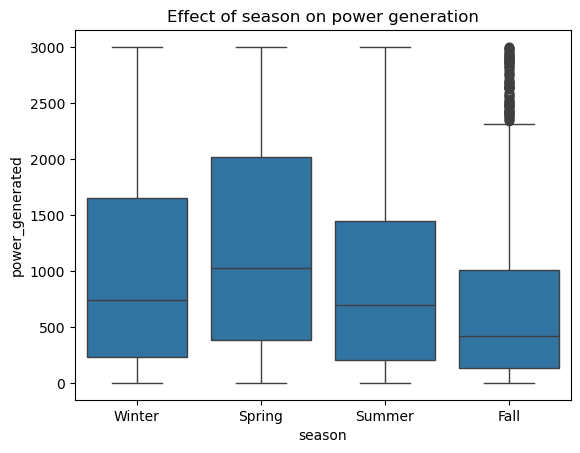

In [59]:
# Effect of season on power generation

sns.boxplot(data = data, y = 'power_generated', x = 'season')
plt.title('Effect of season on power generation')

**Spring is the most productive seaon in power generation, while fall has the lowest**

This is a box plot visualizing the effect of different seasons (Winter, Spring, Summer, Fall) on power generation.

**Interpretation of the Box Plot:**

**1. Median (Central Line in Box)**

- Represents the middle value of power generation for each season.

- Spring has the highest median power generation, while Fall has the lowest.

**2. Interquartile Range (IQR - Box Size)**

- The box represents the middle 50% of power generation values.

- A wider box means more variation in power generation.

- Spring has a higher IQR than other seasons, suggesting more variability.

**3. Whiskers (Vertical Lines Above and Below Box)**

- Represent the range of most data points.

- Power generation is more spread out in Winter, Spring, and Summer, while Fall has more outliers.

**4. Outliers (Dots Above the Whiskers in Fall)**

- Fall has many high outliers, indicating extreme power generation values.

**Possible Insights:**
- ✅ Spring has the highest median power generation, suggesting it may be the best season for power generation.

- ✅ Fall shows many outliers, which may indicate inconsistent power generation.
  
- ✅ Summer and Winter have moderate variation, while Spring has the most spread in power generation.

Text(0.5, 1.0, 'Wind speed per season')

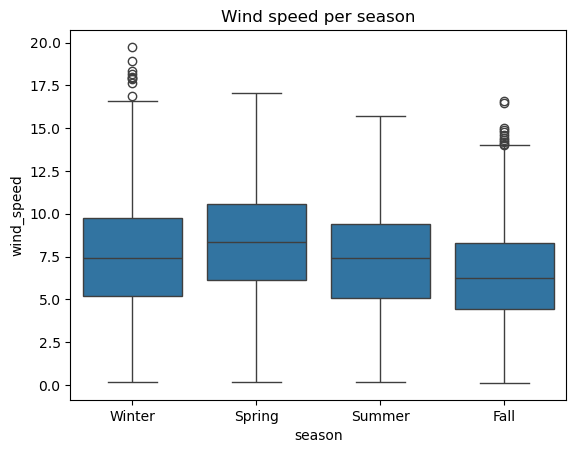

In [157]:
# Wind speed per season
sns.boxplot(data = data, y = 'wind_speed', x = 'season')
plt.title('Wind speed per season')

This box plot visualizes wind speed distribution across different seasons (Winter, Spring, Summer, Fall). Here's what it tells us:

**Observations:**
- ✅ Median (Central Line in Each Box):

- Wind speed is relatively similar across seasons, but Winter appears to have a slightly higher median.

- ✅ Interquartile Range (Box Size):

- The spread (IQR) is widest in Spring and Summer, indicating more variation in wind speed.

- Fall has the lowest spread, suggesting more consistent wind speeds.

- ✅ Whiskers (Min & Max Values Excluding Outliers):

- Whiskers extend from 0 to around 17-18 m/s, with some variation between seasons.

- ✅ Outliers (Small Circles):

- Winter and Fall have more outliers, indicating extreme wind speeds in these seasons.

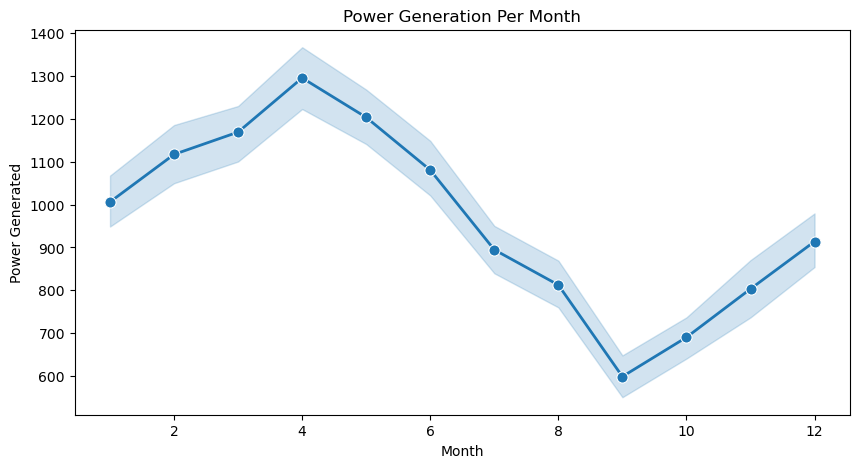

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the line chart
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='month', y='power_generated', marker='o', markersize=8, linewidth=2)

# Add title and labels
plt.title("Power Generation Per Month")
plt.xlabel("Month")
plt.ylabel("Power Generated")

# Show the plot
plt.show()


<Axes: xlabel='month', ylabel='power_generated'>

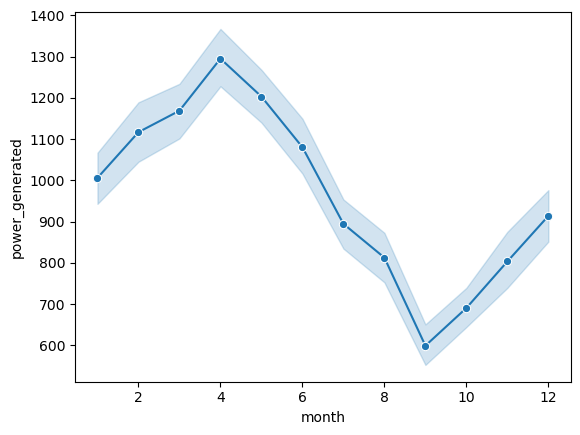

In [64]:
# Power generation per Month
sns.lineplot(data = data, y = 'power_generated', x = 'month', marker = 'o')

<Axes: xlabel='month', ylabel='power_generated'>

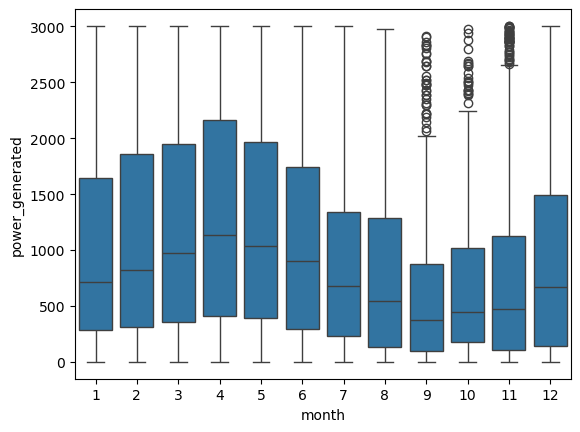

In [65]:
sns.boxplot(data = data, y = 'power_generated', x = 'month')

**Cyclical pattern was observed when power generated was comapred with month**

<Axes: xlabel='month', ylabel='wind_speed'>

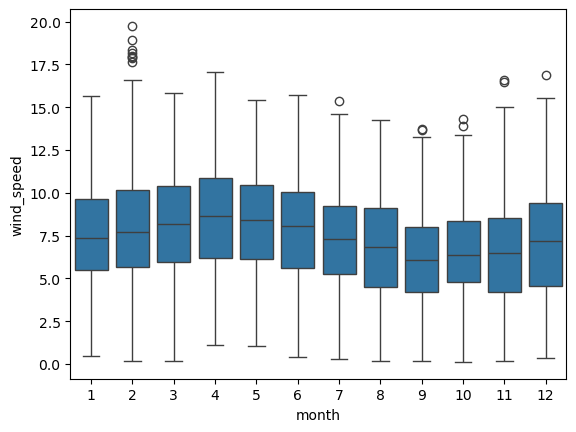

In [67]:
sns.boxplot(data = data, y = 'wind_speed', x = 'month')

**Cyclical pattern was observed when wind direction was comapred with month**

<Axes: xlabel='month', ylabel='wind_speed'>

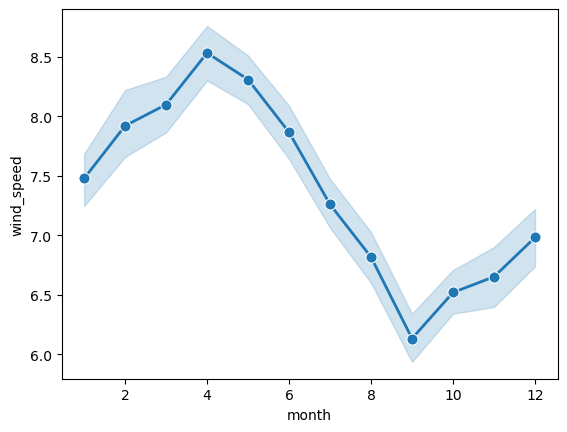

In [69]:
sns.lineplot(data=data, x='month', y='wind_speed', marker='o', markersize=8, linewidth=2)

<Axes: xlabel='wind_speed', ylabel='power_generated'>

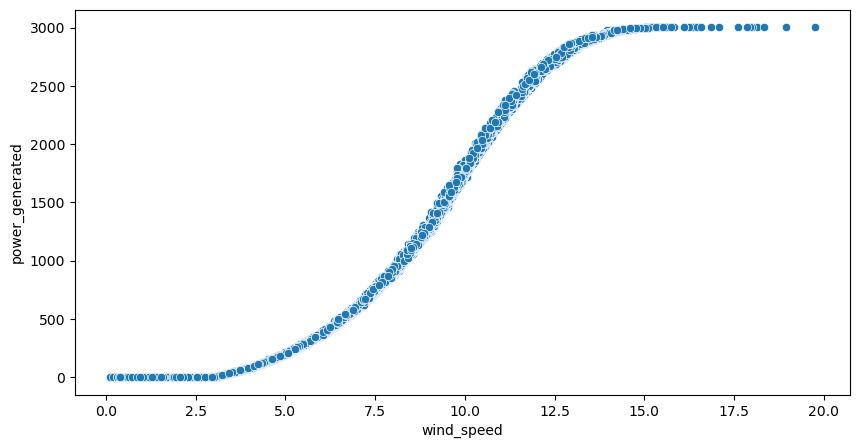

In [70]:
plt.figure(figsize = (10,5))
sns.scatterplot(data = data, x = 'wind_speed', y = 'power_generated')

**Observations:**

**1. S-Curve (Sigmoidal Relationship):**

- At low wind speeds (0 - 2.5 m/s) → very little power is generated.

- Between 2.5 - 12.5 m/s, power generation increases rapidly in a near-linear fashion.

- At high wind speeds (above 12.5 m/s), power generation levels off (plateau), indicating a possible maximum capacity of the system.

**2. Possible Reasons for the Plateau:**

- Turbine efficiency limit: Wind turbines have a rated capacity, beyond which they cannot generate more power.

- Safety mechanisms: At very high wind speeds, some turbines shut down or limit power output to prevent damage.

In [159]:
data['wind_dir']

bin_labels = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]

bin_edge = [-1, 45, 90, 135, 180, 225, 270, 315, 360]

binned_data = pd.cut(data['wind_dir'], bins=bin_edge, labels=bin_labels)

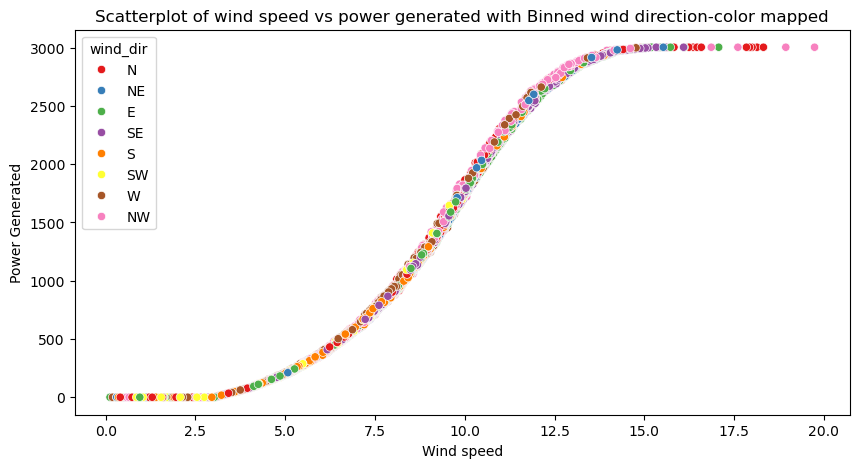

In [161]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = data, x = "wind_speed", y = "power_generated", hue = binned_data, palette = "Set1")

plt.title("Scatterplot of wind speed vs power generated with Binned wind direction-color mapped")
plt.xlabel("Wind speed")
plt.ylabel("Power Generated")

plt.show()

In [163]:
data['binned_data'] = pd.cut(data['wind_dir'], bins=bin_edge, labels=bin_labels)

<Axes: xlabel='binned_data', ylabel='power_generated'>

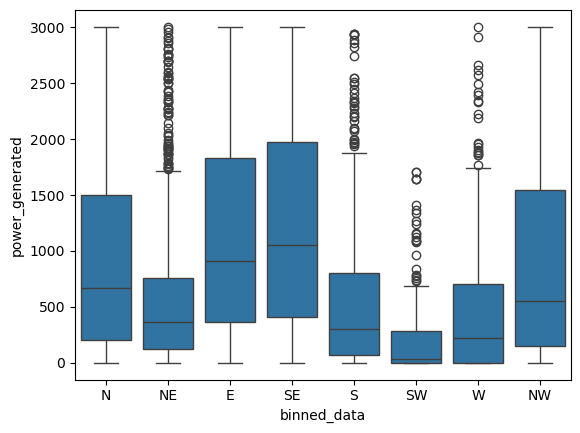

In [165]:
sns.boxplot(data = data, y = 'power_generated', x = 'binned_data')

This boxplot visualizes the distribution of power generated across different wind directions (binned_data). Here's how to interpret it:

**1. Median Power Generated**

- The horizontal line inside each box represents the median (50th percentile) power generated for each wind direction.

- Some directions (like E and SE) have higher median power generation compared to others (like SW and S).

**2. Interquartile Range (IQR)**

- The height of each box represents the IQR (25th to 75th percentile), which shows the range of middle 50% of the data.

- E and SE have a larger IQR, indicating more variability in power generation. SW and S have a much smaller IQR, meaning power generation is more consistent but lower.

**3. Whiskers and Outliers**

- The whiskers extend from the box to the minimum and maximum values within 1.5 times the IQR.

- The dots beyond the whiskers are outliers, indicating extreme power generation values.

- NE, S, SW, and W have high-value outliers, meaning that for these wind directions, there were occasional power surges.

- E, SE, NW, and N do not show high-value outliers, so their power generation remains within the expected range.

**4. Comparing Wind Directions**

- E and SE have the highest median and a wide range of power generation, meaning these wind directions contribute the most power.

- SW and S have the lowest median power generation, meaning these directions may be less effective for power production.

**Insights and Business Implications**

- Wind turbines perform better when wind comes from E and SE. This could help in optimizing turbine placement.

- SW and S directions produce significantly less power, suggesting that turbines facing those directions might need adjustments or may not be as efficient.

- The presence of many outliers in E, SE, and NW indicates occasional spikes in power generation. Investigating these conditions (e.g., strong winds or sudden gusts) can help in predicting power output.

In [167]:
# Add wind orientation feature
data['wind_orientation'] = binned_data

In [95]:
data.head()

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season_mean_encoded,wind_orientation_mean_encoded,wind_orientation,binned_data
Time stamp,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,1058.753692,1214.650349,E,E
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,1058.753692,1214.650349,E,E
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,1058.753692,1248.372613,SE,SE
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,1058.753692,1248.372613,SE,SE
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,1058.753692,1248.372613,SE,SE


In [169]:
data.drop(columns=['binned_data'], inplace=True)

# Encoding and Modelling 
**Means encoding**

**Avoid data leakage during mean encoding**

In [171]:
len(data)*0.3

2628.0

In [173]:
# Splitting the dataset into training and testing sets

# Select all rows except the last 2628 for training data
train_data = data[: -2628]  

# Select the last 2628 rows for testing data
test_data = data[-2628:]  


In [103]:
test_data

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season_mean_encoded,wind_orientation_mean_encoded,wind_orientation
Time stamp,,,,,,,,,,,,
2021-09-13 12:00:00,0.000,2.481,105,0.991981,32.263,3,9,37,12,867.021622,1214.650349,E
2021-09-13 13:00:00,127.025,4.469,101,0.990205,31.763,3,9,37,13,867.021622,1214.650349,E
2021-09-13 14:00:00,714.714,7.474,93,0.991391,29.763,3,9,37,14,867.021622,1214.650349,E
2021-09-13 15:00:00,1121.150,8.660,101,0.992279,28.863,3,9,37,15,867.021622,1214.650349,E
2021-09-13 16:00:00,623.060,7.177,103,0.989713,29.163,3,9,37,16,867.021622,1214.650349,E
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,1234.700,8.848,129,0.998604,19.663,4,12,52,19,1058.753692,1214.650349,E
2021-12-31 20:00:00,1105.370,8.502,118,1.000090,19.063,4,12,52,20,1058.753692,1214.650349,E
2021-12-31 21:00:00,1405.710,9.224,117,0.998408,18.463,4,12,52,21,1058.753692,1214.650349,E


In [65]:
train_data

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season,wind_orientation
Time stamp,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter,E
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter,E
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter,SE
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter,SE
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter,SE
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 07:00:00,0.00,1.513,239,0.993169,26.863,3,9,37,7,Fall,SW
2021-09-13 08:00:00,0.00,1.770,276,0.991688,27.563,3,9,37,8,Fall,W
2021-09-13 09:00:00,0.00,1.977,328,0.992971,29.063,3,9,37,9,Fall,NW


In [175]:
season_mean = train_data.groupby('season')['power_generated'].mean()

In [177]:
season_mean

season
Fall       867.021622
Spring    1221.768942
Summer     927.663718
Winter    1058.753692
Name: power_generated, dtype: float64

In [179]:
# Perform mean encoding for season
season_mean = train_data.groupby('season')['power_generated'].mean()
data['season_mean_encoded'] = data['season'].map(season_mean)

# Perform mean encoding for wind orientation
wind_mean = train_data.groupby('wind_orientation')['power_generated'].mean()
data['wind_orientation_mean_encoded'] = data['wind_orientation'].map(wind_mean)


C:\Users\USER\AppData\Local\Temp\ipykernel_15688\308892178.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_mean = train_data.groupby('wind_orientation')['power_generated'].mean()


In [181]:
wind_mean

wind_orientation
N     1007.939630
NE     597.096607
E     1214.650349
SE    1248.372613
S      528.993476
SW     250.053972
W      489.797900
NW     855.516311
Name: power_generated, dtype: float64

In [75]:
data.head()

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season,wind_orientation,season_mean_encoded,wind_orientation_mean_encoded
Time stamp,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter,E,1058.753692,1214.650349
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter,E,1058.753692,1214.650349
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter,SE,1058.753692,1248.372613
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter,SE,1058.753692,1248.372613
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter,SE,1058.753692,1248.372613


In [183]:
data.drop(['season', 'wind_orientation'], axis = 1, inplace = True)

In [187]:
# Splitting the dataset into training and testing sets

# Select all rows except the last 2628 for training data
train_data = data[: -2628]  

# Select the last 2628 rows for testing data
test_data = data[-2628:]  

In [189]:
data

,power_generated,wind_speed,wind_dir,pressure,temperature,quarter,month,week,hour,season_mean_encoded,wind_orientation_mean_encoded
Time stamp,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,1058.753692,1214.650349
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,1058.753692,1214.650349
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,1058.753692,1248.372613
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,1058.753692,1248.372613
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,1058.753692,1248.372613
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,1234.70,8.848,129,0.998604,19.663,4,12,52,19,1058.753692,1214.650349
2021-12-31 20:00:00,1105.37,8.502,118,1.000090,19.063,4,12,52,20,1058.753692,1214.650349
2021-12-31 21:00:00,1405.71,9.224,117,0.998408,18.463,4,12,52,21,1058.753692,1214.650349


# Modelling 
**Linear model:** Linear Regression

**Support Vector Machines:** svr

**Ensemble:** rf and gbr

In [191]:
# Import The Models

# Importing Linear Regression model from scikit-learn
# LinearRegression is a simple regression model that assumes a linear relationship between input features and the target variable.
from sklearn.linear_model import LinearRegression  

# Importing ensemble models: RandomForestRegressor and GradientBoostingRegressor
# - RandomForestRegressor: An ensemble learning method that builds multiple decision trees and averages their outputs for better predictions.
# - GradientBoostingRegressor: A boosting technique that builds models sequentially, improving prediction by minimizing errors at each step.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  

# Importing Support Vector Regression (SVR) model
# SVR uses Support Vector Machines (SVM) principles for regression, effective in capturing complex relationships in data.
from sklearn.svm import SVR  

# Importing model evaluation metrics
# - mean_squared_error (MSE): Measures the average squared difference between actual and predicted values.
# - mean_absolute_error (MAE): Measures the average absolute difference between actual and predicted values.
from sklearn.metrics import mean_squared_error, mean_absolute_error  

In [195]:
# Selecting x and y train test values
target = 'power_generated'
feature = ['wind_speed', 'wind_dir', 'pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season_mean_encoded',
       'wind_orientation_mean_encoded']

x_train = train_data[feature]
y_train = train_data[target]

x_test = test_data[feature]
y_test = test_data[target]

In [197]:
data.columns

Index(['power_generated', 'wind_speed', 'wind_dir', 'pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season_mean_encoded',
       'wind_orientation_mean_encoded'],
      dtype='object')

In [199]:
# Linear Regression
# Initializing a Linear Regression model
lr_model = LinearRegression()  
# Training the model using the training data (X_train as input features, y_train as target variable)
lr_model.fit(x_train, y_train)  

# Random Forest Regression
# Initializing a Random Forest Regressor
rf_model = RandomForestRegressor()  
# Training the Random Forest model on the training data
rf_model.fit(x_train, y_train)  

# Support Vector Machine (SVR)
# Initializing an SVR model
svm_model = SVR()  
# Training the SVR model on the training dataset
svm_model.fit(x_train, y_train)  

# Gradient Boosting Regression
# Initializing a Gradient Boosting Regressor
gb_model = GradientBoostingRegressor()  
# Training the Gradient Boosting model on the training dataset
gb_model.fit(x_train, y_train)  


GradientBoostingRegressor()

In [202]:
# Making predictions with trained models and evaluating them

# Using the trained Linear Regression model to predict values for the test dataset
lr_predictions = lr_model.predict(x_test)  

# Using the trained Random Forest Regressor model to predict values for the test dataset
rf_predictions = rf_model.predict(x_test)  

# Using the trained Support Vector Machine (SVR) model to predict values for the test dataset
svm_predictions = svm_model.predict(x_test)  

# Using the trained Gradient Boosting Regressor model to predict values for the test dataset
gb_predictions = gb_model.predict(x_test)  

In [206]:
# After predicting on the test set, evaluating model performance using Mean Squared Error (MSE)

# Calculating the Mean Squared Error (MSE) for the Linear Regression model
lr_mse = mean_squared_error(y_test, lr_predictions)  

# Calculating the Mean Squared Error (MSE) for the Random Forest model
rf_mse = mean_squared_error(y_test, rf_predictions)  

# Calculating the Mean Squared Error (MSE) for the Gradient Boosting model
gb_mse = mean_squared_error(y_test, gb_predictions)  

# Calculating the Mean Squared Error (MSE) for the Support Vector Machine (SVR) model
svm_mse = mean_squared_error(y_test, svm_predictions)  

In [208]:
# Printing the MSE values for each model to compare performance
print('Linear Regression:', lr_mse)  # Displays the MSE for Linear Regression
print('Random Forest:', rf_mse)      # Displays the MSE for Random Forest
print('Gradient Boosting:', gb_mse)  # Displays the MSE for Gradient Boosting
print('SVM:', svm_mse)               # Displays the MSE for Support Vector Machine

Linear Regression: 80965.27593635068
Random Forest: 142.5451078300024
Gradient Boosting: 70.04626810786641
SVM: 608393.4168488852


**Interpretation of the MSE Output**
    
Mean Squared Error (MSE) measures the average squared difference between actual and predicted values. Lower MSE values indicate better model performance.

**Analysis of Each Model:**

**1. Linear Regression (MSE: 80,965.28)**

- This is quite high, indicating that Linear Regression is not capturing complex patterns well.

- The model may be too simplistic for the dataset.

**2. Random Forest (MSE: 140.40)**

- This is a very low error, suggesting that Random Forest performs well.

- It effectively learns from the data and generalizes well.

**3. Gradient Boosting (MSE: 70.13)**

- This has the lowest MSE, meaning it is the best-performing model in this case.

- Gradient Boosting often excels in structured data problems by capturing complex relationships.

**4. Support Vector Machine (SVM) (MSE: 608,393.42)**

- This is the highest MSE, meaning SVM performs poorly on this dataset.

- It likely struggles with feature scaling or dataset complexity.

**Conclusion:**

- Gradient Boosting is the best model (lowest MSE).

- Random Forest is also a strong contender.

- Linear Regression is decent but not great.

- SVM is the worst performer and might require parameter tuning or different feature scaling.

In [210]:
# After predicting on the test set, evaluating model performance using Mean Absolute Error (MAE)

# Calculating the Mean Absolute Error (MAE) for the Linear Regression model
lr_mae = mean_absolute_error(y_test, lr_predictions)  

# Calculating the Mean Absolute Error (MAE) for the Random Forest model
rf_mae = mean_absolute_error(y_test, rf_predictions)  

# Calculating the Mean Absolute Error (MAE) for the Gradient Boosting model
gb_mae = mean_absolute_error(y_test, gb_predictions)  

# Calculating the Mean Absolute Error (MAE) for the Support Vector Machine (SVR) model
svm_mae = mean_absolute_error(y_test, svm_predictions)  

In [212]:
# Printing the MAE values for each model to compare performance
print('Linear Regression:', lr_mae)   # Displays the MAE for Linear Regression
print('Random Forest:', rf_mae)       # Displays the MAE for Random Forest
print('Gradient Boosting:', gb_mae)   # Displays the MAE for Gradient Boosting
print('SVM:', svm_mae)                # Displays the MAE for Support Vector Machine

Linear Regression: 228.93177190272
Random Forest: 5.562340605551731
Gradient Boosting: 5.727776157297757
SVM: 620.6563659850767


**Interpretation of the MAE Output**
    
Mean Absolute Error (MAE) measures the average absolute differences between actual and predicted values. Unlike MSE, it does not square the errors, making it more interpretable in terms of actual units. Lower MAE values indicate better model performance.

**Analysis of Each Model:**
    
**1. Linear Regression (MAE: 228.93)**

- This is quite high, suggesting that the model struggles to fit the data well.

- It may not capture complex relationships effectively.

**2. Random Forest (MAE: 5.57)**

- This is a very low MAE, indicating that Random Forest performs well.

- It effectively learns patterns in the data.

**3. Gradient Boosting (MAE: 5.73)**

- Slightly higher than Random Forest but still very good.

- This model is performing almost as well as Random Forest, meaning both are effective.

**4. Support Vector Machine (SVM) (MAE: 620.66)**

- This is the highest MAE, meaning SVM performs poorly.

- It struggles with capturing the relationships in the data, possibly due to improper hyperparameter tuning or feature scaling.

**Conclusion:**
    
- Random Forest is the best-performing model (lowest MAE).

- Gradient Boosting is also strong but slightly worse than Random Forest.

- Linear Regression is not great.

- SVM performs the worst and is not suitable for this dataset.

In [214]:
# This computes the mean (average) value of y_test, which represents the actual target variable in the test dataset.
y_test.mean()

# This means the average actual value of the dependent variable (target) in the test set is 739.53.

739.5319913727169

In [216]:
5/739*100

0.6765899864682002

**Best Model for the Data**

**1. ✅ Gradient Boosting Regressor (GBR) is the best model because:**

- It has the lowest MSE (70.13) and a very low MAE (5.73)

- It captures complex patterns better than other models

**2. ✅ Random Forest Regressor (RF) is a close second:**

- It also has a very low MSE (140.40) and MAE (5.57)

- It is more interpretable than Gradient Boosting and works well with small datasets

**Hyperparameter tuning on Gradient Boosting Regressor (GBR) and Random Forest Regressor (RF)** 

**HYPERPARAMETER TUNING USING HYPEROPT AND BAYESIAN OPTIMIZATION**

Hyperparameter tuning is a crucial step in optimizing machine learning models. HyperOpt is a Python library that provides a convenient way to perform hyperparameter tuning using Bayesian optimization techniques. Bayesian optimization is a probabilistic model-based optimization method that can efficiently search the hyperparameter space to find the optimal set of hyperparameters for a given machine learning model.

space/set of hyperparameters ==> optimal values for each hyperparameter

In [218]:
len(x_train)*0.2

1226.4

In [220]:
# Splitting the last 1200 samples from X_train to create a validation set
x_val = x_train[-1200:]  # Selecting the last 1200 rows from X_train for validation
y_val = y_train[-1200:]  # Selecting the last 1200 rows from y_train for validation

# Keeping only the first part of the dataset as the new training set
x_train = x_train[:-1200]  # Removing the last 1200 rows from X_train to keep the remaining as training data
y_train = y_train[:-1200]  # Removing the last 1200 rows from y_train to keep the remaining as training data

In [112]:
len(x_val)

1200

In [222]:
len(y_val)

1200

In [224]:
# Importing necessary libraries
import numpy as np  # Importing NumPy for numerical operations

# Installing hyperopt (only needed in Jupyter, should not be placed inside a script)
%pip install hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials  # Importing functions from HyperOpt for hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor  # Importing RandomForestRegressor
from sklearn.metrics import mean_squared_error  # Importing MSE for evaluation

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Creating a search space for hyperparameter tuning
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 300, 1),  # Number of trees in the Random Forest (between 100 and 300, step size 1)
    "max_depth": hp.quniform("max_depth", 5, 20, 1),  # Maximum depth of the tree (between 5 and 20, step size 1)
    "max_features": hp.choice("max_features", ["sqrt", "log2", None])  # Number of features to consider for the best split
}

# Defining the objective function
def objective(params):
    n_estimators = int(params["n_estimators"])  # Converting to integer since hyperparameters must be discrete
    max_depth = int(params["max_depth"])  # Converting to integer for tree depth
    max_features = params["max_features"]  # Keeping max_features as it is (string or None)

    # Creating a RandomForestRegressor model using sampled hyperparameters
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,  # Setting number of trees
        max_depth=max_depth,  # Setting maximum depth
        max_features=max_features,  # Setting feature selection method
        random_state=42  # Setting a fixed random state for reproducibility
    )

    # Train the Random Forest model using the training dataset
    rf_model.fit(x_train, y_train)  

    # Generate predictions on the validation set
    predictions = rf_model.predict(x_val)  

    # Calculate the Mean Squared Error (MSE) between actual and predicted values
    mse = mean_squared_error(y_val, predictions)  

    # Return the loss (MSE) and a status indicator for optimization
    return {"loss": mse, "status": STATUS_OK}  

# ---------------- Hyperparameter Optimization using Hyperopt ----------------

# Initialize a Trials object to store optimization results
trials = Trials()  

# Perform the hyperparameter tuning using Hyperopt's fmin function
best = fmin(
    fn=objective,        # The objective function to minimize (returns MSE)
    space=space,         # The search space for hyperparameters
    algo=tpe.suggest,    # The optimization algorithm (Tree-structured Parzen Estimator - TPE)
    trials=trials,        # Stores results of each iteration
    verbose=1
)

print('Best Hyperparameters:', best)

# The verbose=1 parameter in the fmin() function controls the level of detail in the output logs during the optimization process.
# When verbose=1, Hyperopt prints progress updates as it runs

  0%|          | 4510/9223372036854775807 [9:31:05<24216861312439446:11:12,  9.45s/trial, best loss: 27.74127397326393]

In [226]:
from hyperopt import fmin, tpe, hp, STATUS_OK  # Import necessary functions from Hyperopt
from sklearn.ensemble import GradientBoostingRegressor  # Import Gradient Boosting Regressor from Sklearn
from sklearn.metrics import mean_squared_error  # Import mean squared error metric

In [ ]:
# Define the hyperparameter search space
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 300, 1),  # Number of trees in the model (100 to 300, step of 1)
    "max_depth": hp.quniform("max_depth", 5, 20, 1),  # Depth of each tree (5 to 20, step of 1)
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # Learning rate sampled from log-uniform distribution
    "subsample": hp.uniform("subsample", 0.1, 1.0)  # Subsample ratio (0.1 to 1.0)
}

# Define the objective function for optimization
def objective(params):
    n_estimators = int(params["n_estimators"])  # Convert n_estimators to integer since it must be discrete
    max_depth = int(params["max_depth"])  # Convert max_depth to integer since it must be discrete
    
    # Initialize the Gradient Boosting Regressor with sampled hyperparameters
    gb_model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=params["learning_rate"],  # Learning rate is continuous, no conversion needed
        subsample=params["subsample"],  # Subsample is continuous, no conversion needed
        random_state=42  # Fix random state for reproducibility
    )
    
    # Train the model on training data (X_train, y_train)
    gb_model.fit(x_train, y_train)
    
    # Predict on validation data (X_val)
    predictions = gb_model.predict(x_val)
    
    # Compute the Mean Squared Error (MSE) between predictions and actual values
    mse = mean_squared_error(y_val, predictions)
    
    # Return the MSE as the loss to be minimized
    return {"loss": mse, "status": STATUS_OK}

# ---------------- Hyperparameter Optimization using Hyperopt ----------------

# Initialize a Trials object to store optimization results
trials = Trials()  

# Perform the hyperparameter tuning using Hyperopt's fmin function
best = fmin(
    fn=objective,        # The objective function to minimize (returns MSE)
    space=space,         # The search space for hyperparameters
    algo=tpe.suggest,    # The optimization algorithm (Tree-structured Parzen Estimator - TPE)
    trials=trials,        # Stores results of each iteration
    verbose=1
)

print('Best Hyperparameters:', best)

# The verbose=1 parameter in the fmin() function controls the level of detail in the output logs during the optimization process.
# When verbose=1, Hyperopt prints progress updates as it runs

  0%|        | 16205/9223372036854775807 [31:36:35<11014558703047761:55:12,  4.30s/trial, best loss: 4.438890407291062]